# Twin Neural Network for analyzing diffraction images

In [1]:
import socket
print(socket.gethostname())

tur016


In [2]:
%matplotlib notebook

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random
import sys
import h5py
#import pydot
import graphviz
from sklearn.decomposition import PCA

print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.1.0


In [3]:
particle2idx = {
    '1fpv': 0,
    '1ss8': 1,
    '3j03': 2,
    '1ijg': 3,
    '3iyf': 4,
    '6ody': 5,
    '6sp2': 6,
    '6xs6': 7,
    '7dwz': 8,
    '7dx8': 9,
    '7dx9': 10
}

count2idx = {
    'single': 0,
    'double': 1,
    'triple': 2,
    'quadruple': 3
}

hit2idx = {
    'single_hit': 0,
    'multi_hit': 1
}

In [4]:
idx2particle = {
    0: '1fpv',
    1: '1ss8',
    2: '3j03',
    3: '1ijg',
    4: '3iyf',
    5: '6ody',
    6: '6sp2',
    7: '6xs6',
    8: '7dwz',
    9: '7dx8',
    10: '7dx9'
}

idx2count = {
    0: 'single',
    1: 'double',
    2: 'triple',
    3: 'quadruple'
}

idx2hit = {
    0: 'single_hit',
    1: 'multi_hit'
}

# Data Augmentation

In [5]:
def addNoise(orig_img, flux_jitter=0.9, gaussian_noise=0.15):
    
    """
    Adds augmentations and noise to batches of diffraction images.
    
    The following augmentations are applied to images:
    1. Random rotation between (-360, 360).
    2. Random vertical and horizontal flips.
    3. Random zoom-in and zoom-out between (0.9x, 1.1x)
    
    The following noise are applied to images:
    1. Reduce the fluence by a factor of 100.
    2. Add poisson noise.
    3. Add gaussian noise given a sigma value.
    4. Varience normalization.
    
    Parameters
    ----------
    orig_img: list(numpy.array)
        Batch of diffraction images represented by numpy.array
    flux_jitter: float
        Flux jitter to include when reducing fluence of images.
    gaussian_noise: float
        Alias for sigma used in gaussian distribution; specifies how much gaussian noise to include in the images.
    
    Return
    ------
    Batch of transformed images from orig_img.
    """

    def changeIntensity(img, flux_jitter):
        factor = 100 # Reduces the fluence of the image by a factor of 100. Ex. 1e14 photons/pulse -> 1e12 photons/pulse.
        mu = 1 # mean jitter
        alpha = np.random.normal(mu, flux_jitter)
        if alpha <= 0: alpha = 0.1 # alpha can't be zero
        n_photons = alpha*np.sum(img) / factor                     # number of desired photons per image
        return n_photons*(img/np.sum(img)) # cache noise-free measurement
    
    def poisson(img):
        # add poisson noise
        return np.random.poisson(img)      # apply Poisson statistics
    
    def gaussian(img, sigma):
        # add gaussian noise 
        # For random samples from N(\mu, \sigma^2), 
        # mu + sigma * np.random.randn(...)
        # sigma: Gaussian noise level
        img = img + sigma*np.random.randn(*img.shape);  # apply Gaussian statistics
        return img
    
    def varNorm(V):
        # variance normalization, each image has mean 0, variance 1
        # This shouldn't happen, but zero out infinite pixels
        V[np.argwhere(V==np.inf)] = 0
        mean = np.mean(V)
        std = np.std(V)
        if std == 0:
            return np.zeros_like(V)
        V1 = (V-mean)/std
        return V1
    
    def rotation_transform(img, rotation_range):
        img = np.expand_dims(img, axis=2)
        img = tf.keras.preprocessing.image.random_rotation(x=img, rg=rotation_range, row_axis=0, col_axis=1, channel_axis=2,
                                                           fill_mode='constant', cval=0.0)
        img = np.squeeze(img)
        return img
    
    def vertical_flip_transform(img):
        img = np.expand_dims(img, axis=2)
        img = tf.image.random_flip_left_right(img).numpy()
        img = np.squeeze(img)
        return img
    
    def horizontal_flip_transform(img):
        img = np.expand_dims(img, axis=2)
        img = tf.image.random_flip_up_down(img).numpy()
        img = np.squeeze(img)
        return img
    
    def zoom_transform(img, zoom_range):
        img = np.expand_dims(img, axis=2)
        img = tf.keras.preprocessing.image.random_zoom(x=img, zoom_range=zoom_range, row_axis=0, col_axis=1, channel_axis=2,
                                                       fill_mode='constant', cval=0.0)
        img = np.squeeze(img)
        return img

    def transform(img):
        # Apply rotation, flips, and zooms before other noise.
        img = rotation_transform(img, rotation_range=360)
        img = vertical_flip_transform(img)
        img = horizontal_flip_transform(img)
        img = zoom_transform(img, zoom_range=(0.9, 1.1))
        
        img = changeIntensity(img, flux_jitter)
        img = poisson(img)
        img = gaussian(img, gaussian_noise)
        img = varNorm(img)
        return img
    
    # "orig_img" is actually a "mini-batch" of images.
    # This loops applies the transforms to every image in that "mini-batch"
    for i in range(orig_img.shape[0]):
        orig_img[i] = transform(img=orig_img[i])
    
    return orig_img

# Data Loader Function

#### Loads data and label them by count

In [6]:
def load_data(num_train_samples=200, num_test_samples=50, normalize=None, seed=None):
    """
    Loads the data that will be used for model training. Labels diffraction images
    by their respective particle count.
    
    Parameters
    ----------
    num_train_samples: int
        Number of training samples to include in training dataset.
    num_test_samples: int
        Number of test samples to include in test dataset.
    normalize: str
        Type of intensity normalization.
        Pick from the following: {'variance'}
    seed: int
        Seed used to randomly split the data.
            
    Return
    ------
    (x_train, y_train): List of diffraction images and their labels, with a size of num_train_samples.

    (x_test, y_test): List of diffraction images and their labels, with a size of num_test_samples.
    """
    
    # num_train_sample must be divisible by 2
    # TODO: Change path to proper location.
    path = '/scratch/xericfl/eric_data/'
    
    # Filenames for datasets containing diffraction image thumbnails.
    fnames = ['1fpv_5k_single_pps_1e14_thumbnail.h5',
            '6sp2_5k_single_pps_1e14_thumbnail.h5',
            '1ijg_5k_single_pps_1e14_thumbnail.h5',
            '6xs6_5k_single_pps_1e14_thumbnail.h5',
            '1ss8_5k_single_pps_1e14_thumbnail.h5',
            '7dwz_5k_single_pps_1e14_thumbnail.h5',
            '3iyf_5k_single_pps_1e14_thumbnail.h5',
            '7dx8_5k_single_pps_1e14_thumbnail.h5',
            '3j03_5k_single_pps_1e14_thumbnail.h5',
            '7dx9_5k_single_pps_1e14_thumbnail.h5',
            '6ody_5k_single_pps_1e14_thumbnail.h5',
            '1fpv_5k_double_pps_1e14_thumbnail.h5',
            '6sp2_5k_double_pps_1e14_thumbnail.h5',
            '1ijg_5k_double_pps_1e14_thumbnail.h5',
            '6xs6_5k_double_pps_1e14_thumbnail.h5',
            '1ss8_5k_double_pps_1e14_thumbnail.h5',
            '7dwz_5k_double_pps_1e14_thumbnail.h5',
            '3iyf_5k_double_pps_1e14_thumbnail.h5',
            '7dx8_5k_double_pps_1e14_thumbnail.h5',
            '3j03_5k_double_pps_1e14_thumbnail.h5',
            '7dx9_5k_double_pps_1e14_thumbnail.h5',
            '6ody_5k_double_pps_1e14_thumbnail.h5',
            '1fpv_5k_triple_pps_1e14_thumbnail.h5',
            '6sp2_5k_triple_pps_1e14_thumbnail.h5',
            '1ijg_5k_triple_pps_1e14_thumbnail.h5',
            '6xs6_5k_triple_pps_1e14_thumbnail.h5',
            '1ss8_5k_triple_pps_1e14_thumbnail.h5',
            '7dwz_5k_triple_pps_1e14_thumbnail.h5',
            '3iyf_5k_triple_pps_1e14_thumbnail.h5',
            '7dx8_5k_triple_pps_1e14_thumbnail.h5',
            '3j03_5k_triple_pps_1e14_thumbnail.h5',
            '7dx9_5k_triple_pps_1e14_thumbnail.h5',
            '6ody_5k_triple_pps_1e14_thumbnail.h5',
            '1fpv_5k_quadruple_pps_1e14_thumbnail.h5',
            '6sp2_5k_quadruple_pps_1e14_thumbnail.h5',
            '1ijg_5k_quadruple_pps_1e14_thumbnail.h5',
            '6xs6_5k_quadruple_pps_1e14_thumbnail.h5',
            '1ss8_5k_quadruple_pps_1e14_thumbnail.h5',
            '7dwz_5k_quadruple_pps_1e14_thumbnail.h5',
            '3iyf_5k_quadruple_pps_1e14_thumbnail.h5',
            '7dx8_5k_quadruple_pps_1e14_thumbnail.h5',
            '3j03_5k_quadruple_pps_1e14_thumbnail.h5',
            '7dx9_5k_quadruple_pps_1e14_thumbnail.h5',
            '6ody_5k_quadruple_pps_1e14_thumbnail.h5']
    
    # Number of files to go through.
    numFiles = len(fnames)
    
    # Initialize numpy random number generator.
    if seed is not None: 
        np.random.seed(seed)
    
    # Get image dimensions
    with h5py.File(path+fnames[0],'r') as f:
        img = f['photons'][0,:,:]
        nR,nC = img.shape
            
    # TRAIN
    x_train = np.empty((num_train_samples, nR, nC), dtype='float32')
    y_train = np.empty((num_train_samples,), dtype='uint8')
    index = np.random.randint(0, numFiles, num_train_samples)
    for i, fname in enumerate(fnames):
        ind = np.where(index == i)[0]
        if len(ind) > 0:
            with h5py.File(path+fname,'r') as f:
                
                # Apply augmentations and noise to image.
                x_train[ind] = addNoise(f['photons'][0:len(ind),:,:], flux_jitter=0.9, gaussian_noise=0.15)
                print(fname, len(ind))
                
                # Set particle count label
                if 'single' in fname:
                    y_train[ind] = hit2idx['single_hit']
                elif ('double' in fname) or ('triple' in fname) or ('quadruple' in fname):
                    y_train[ind] = hit2idx['multi_hit']
                else:
                    raise Exception('Unknown file being processed. Be sure that one of the following count types are in the file name: \"single\", \"double\", \"triple\", or \"quadruple\"')


    # TEST
    x_test = np.empty((num_test_samples, nR, nC), dtype='float32')
    y_test = np.empty((num_test_samples,), dtype='uint8')
    index = np.random.randint(0,numFiles,num_test_samples)
    for i, fname in enumerate(fnames):
        ind = np.where(index == i)[0] 
        if len(ind) > 0:
            with h5py.File(path+fname,'r') as f:
                # apply offset since first num_train_samples have been used
                offset = round(num_train_samples/numFiles)
                
                # Apply augmentations and noise to image.
                x_test[ind] = addNoise(f['photons'][offset:len(ind)+offset,:,:], flux_jitter=0.9, gaussian_noise=0.15)
                
                # Set particle count label.
                if 'single' in fname:
                    y_test[ind] = hit2idx['single_hit']
                elif ('double' in fname) or ('triple' in fname) or ('quadruple' in fname):
                    y_test[ind] = hit2idx['multi_hit']
                else:
                    raise Exception('Unknown file being processed. Be sure that one of the following count types are in the file name: \"single\", \"double\", \"triple\", or \"quadruple\"')

    
    return (x_train, y_train), (x_test, y_test)

In [7]:
# Load data
(x_train, y_train), (x_test, y_test) = load_data(num_train_samples=200, num_test_samples=50, normalize=None, seed=None)

1fpv_5k_single_pps_1e14_thumbnail.h5 7
6sp2_5k_single_pps_1e14_thumbnail.h5 5
1ijg_5k_single_pps_1e14_thumbnail.h5 5
6xs6_5k_single_pps_1e14_thumbnail.h5 5
1ss8_5k_single_pps_1e14_thumbnail.h5 5
7dwz_5k_single_pps_1e14_thumbnail.h5 5
3iyf_5k_single_pps_1e14_thumbnail.h5 9
7dx8_5k_single_pps_1e14_thumbnail.h5 4
3j03_5k_single_pps_1e14_thumbnail.h5 7
7dx9_5k_single_pps_1e14_thumbnail.h5 4
6ody_5k_single_pps_1e14_thumbnail.h5 6
1fpv_5k_double_pps_1e14_thumbnail.h5 5
6sp2_5k_double_pps_1e14_thumbnail.h5 3
1ijg_5k_double_pps_1e14_thumbnail.h5 6
6xs6_5k_double_pps_1e14_thumbnail.h5 5
1ss8_5k_double_pps_1e14_thumbnail.h5 3
7dwz_5k_double_pps_1e14_thumbnail.h5 2
3iyf_5k_double_pps_1e14_thumbnail.h5 3
7dx8_5k_double_pps_1e14_thumbnail.h5 5
3j03_5k_double_pps_1e14_thumbnail.h5 7
7dx9_5k_double_pps_1e14_thumbnail.h5 4
6ody_5k_double_pps_1e14_thumbnail.h5 3
1fpv_5k_triple_pps_1e14_thumbnail.h5 5
6sp2_5k_triple_pps_1e14_thumbnail.h5 7
1ijg_5k_triple_pps_1e14_thumbnail.h5 8
6xs6_5k_triple_pps_1e14_t

In [8]:
# vectorize dataset
print(x_train.shape)
(num_train, dim_r, dim_c) = x_train.shape
num_test = x_test.shape[0]
img_dim = dim_r * dim_c

x_train = np.reshape(x_train, (num_train, img_dim)) # reshape to vectors
x_test = np.reshape(x_test, (num_test, img_dim))

(200, 128, 128)


In [9]:
# plotting triplet (anchor, positive, negative)
def plot_triplet(triplet, labels):
    plt.figure(figsize=(6,2))
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.imshow(np.reshape(triplet[i], (dim_r, dim_c)), cmap='binary')
        plt.xticks([])
        plt.yticks([])
           
        if i == 0: plt.title('anchor: {}'.format(idx2hit[labels[i].item()]))
        if i == 1: plt.title('positive: {}'.format(idx2hit[labels[i].item()]))
        if i == 2: plt.title('negative: {}'.format(idx2hit[labels[i].item()]))
    plt.show()

In [10]:
# create a batch of triplets
def create_batch(batch_size, anchor_label=None):
    
    # Holds diffraction images for the anchor, positive, and negative triplets.
    anchors = np.zeros((batch_size, img_dim))
    positives = np.zeros((batch_size, img_dim))
    negatives = np.zeros((batch_size, img_dim))
    
    # Holds labels, where [ind, 0] contains PDB ID and [ind, 1] contains count classification.
    anchor_labels = np.zeros((batch_size,), dtype=int)
    positive_labels = np.zeros((batch_size,), dtype=int)
    negative_labels = np.zeros((batch_size,), dtype=int)
    
    for i in range(batch_size):
        
        # Pick an anchor that matches anchor_label if given
        if anchor_label is not None:
            indices_for_anc = np.squeeze(np.where(y_train == anchor_label))
            index = indices_for_anc[np.random.randint(0, len(indices_for_anc)-1)]
        else:
            index = np.random.randint(0, num_train-1)
        
        # Retrieve anchor image and it's label from the given index.
        anc = x_train[index]
        y = y_train[index]
        
        # Get indices for positive and negative images to create triplet pairs.
        indices_for_pos = np.squeeze(np.where(y_train == y))
        indices_for_neg = np.squeeze(np.where(y_train != y))
        
        # Get a random positive image index and negative image index.
        pos_idx = indices_for_pos[np.random.randint(0, len(indices_for_pos)-1)]
        neg_idx = indices_for_neg[np.random.randint(0, len(indices_for_neg)-1)]
        
        # Retrieve positive and negative images from the given pos_idx and neg_idx indices.
        pos = x_train[pos_idx]
        neg = x_train[neg_idx]
        
        # Assign anchor, positive, and negative.
        anchors[i] = anc
        positives[i] = pos
        negatives[i] = neg
        
        # Assign anchor, positive, and negative labels.
        anchor_labels[i] = y
        positive_labels[i] = y_train[pos_idx]
        negative_labels[i] = y_train[neg_idx]
        
    # Returns image batches and (anc, pos, neg) labels
    return [anchors, positives, negatives], [anchor_labels, positive_labels, negative_labels]

<IPython.core.display.Javascript object>


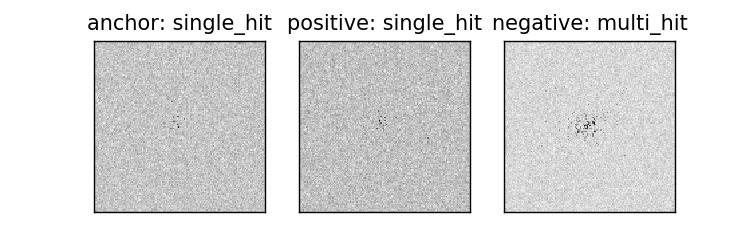

In [11]:
# visualize a batch of triplet
triplet, labels = create_batch(batch_size=1, anchor_label=0)
plot_triplet(triplet, labels)

# Defining the Model

### Define the embedding model
```emb_dim``` defines how many features the embedding model will extra from the diffraction images.

```embedding_model``` defines the model used to create the embedding vectors from diffraction images. This could be a shallow network to a deep network, but the output is always an embedding vector.

In [12]:
# Embedding model (2 dense layers w/ relu and sigmoid activation)

# Experiment with this value.
emb_dim = 32

# Dense implements the operation: output = activation(dot(input, kernel) + bias)

# Experiment with the embedding model's architecture.
embedding_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(emb_dim, activation='relu', input_shape=(img_dim,)),
    tf.keras.layers.Dense(emb_dim, activation='sigmoid')
])

embedding_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                524320    
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
Total params: 525,376
Trainable params: 525,376
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Prints out an example embedding created by a diffraction image using the
# embedding model.
example = x_train[0]
example_emb = embedding_model.predict(np.expand_dims(example, axis=0))
print("example embedding: ", example_emb, example_emb.shape)

example embedding:  [[0.3031244  0.37896517 0.19287527 0.17575495 0.36599174 0.45577756
  0.714512   0.48091853 0.7911651  0.86326116 0.6065046  0.6366145
  0.70723575 0.5076209  0.79439604 0.78714424 0.7716523  0.77902675
  0.36883548 0.84715754 0.4854731  0.3234418  0.9291181  0.6078411
  0.15527803 0.25997105 0.5371252  0.44888866 0.40975943 0.8494575
  0.65729225 0.8046315 ]] (1, 32)


<IPython.core.display.Javascript object>


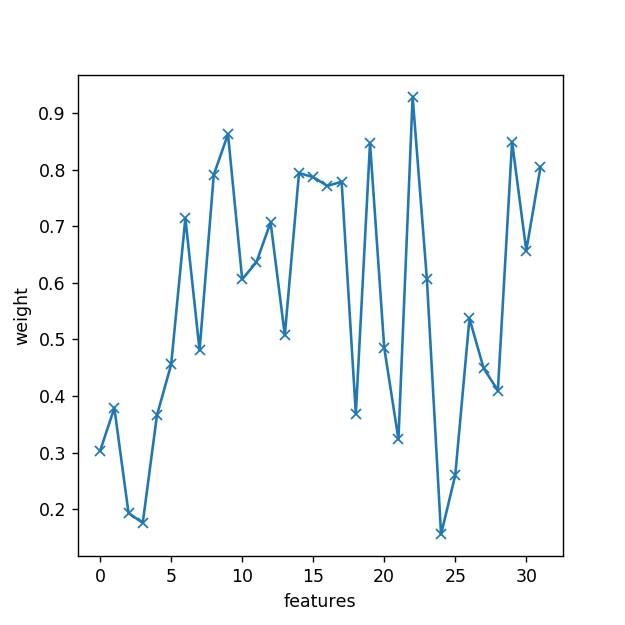

In [14]:
# Plot the example embedding.
plt.figure(figsize=(5,5))
plt.plot(example_emb[0],'x-'); plt.xlabel("features"); plt.ylabel("weight"); plt.show()

### Define the entire network
Here we define the entire twin neural network that we will be using. This includes setting up the Input layers, the embedding model layer, and the output layer.

The three inputs are an anchor diffraction image, a positive diffraction image, and a negative diffraction image. The output is a $1\times(3*\textrm{emb_dim})$ vector.
1. $[0, \textrm{emb_dim})$ contains the embedding weights of the anchor image.
2. $[\textrm{emb_dim}, 2*\textrm{emb_dim})$ contains the embedding weights of the positive image.
3. $[2*\textrm{emb_dim}, 3*\textrm{emb_dim})$ contains the embedding weights of the negative image.

In [15]:
# Siamese network
in_anc = tf.keras.layers.Input(shape=(img_dim,))
in_pos = tf.keras.layers.Input(shape=(img_dim,))
in_neg = tf.keras.layers.Input(shape=(img_dim,))

em_anc = embedding_model(in_anc)
em_pos = embedding_model(in_pos)
em_neg = embedding_model(in_neg)

out = tf.keras.layers.concatenate([em_anc, em_pos, em_neg], axis=1)

net = tf.keras.models.Model(
    [in_anc, in_pos, in_neg],
    out
)

net.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 16384)]      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 16384)]      0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 16384)]      0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 32)           525376      input_1[0][0]                    
                                                                 input_2[0][0]                

# Triplet Loss
A loss function that tries to pull the Embeddings of Anchor and Positive Examples closer, and tries to push the Embeddings of Anchor and Negative Examples away from each other.

Root mean square difference between Anchor and Positive examples in a batch of N images is:
$
\begin{equation}
d_p = \sqrt{\frac{\sum_{i=0}^{N-1}(f(a_i) - f(p_i))^2}{N}}
\end{equation}
$

Root mean square difference between Anchor and Negative examples in a batch of N images is:
$
\begin{equation}
d_n = \sqrt{\frac{\sum_{i=0}^{N-1}(f(a_i) - f(n_i))^2}{N}}
\end{equation}
$

For each example, we want:
$
\begin{equation}
d_p \leq d_n
\end{equation}
$

Therefore,
$
\begin{equation}
d_p - d_n \leq 0
\end{equation}
$

This condition is quite easily satisfied during the training.

We will make it non-trivial by adding a margin (alpha):
$
\begin{equation}
d_p - d_n + \alpha \leq 0
\end{equation}
$

Given the condition above, the Triplet Loss L is defined as:
$
\begin{equation}
L = max(d_p - d_n + \alpha, 0)
\end{equation}
$

In [16]:
def triplet_loss(alpha, emb_dim):
    """
    Triplet Loss function used in training the model.
    
    Parameters
    ----------
    alpha: float
        The alpha margin used in the comparison of anchor-positive distances and anchor-negative distances.
    emb_dim: int
        The size of the embedding vectors.
    """
    def loss(y_true, y_pred):
        anc, pos, neg = y_pred[:, :emb_dim], y_pred[:, emb_dim:2*emb_dim], y_pred[:, 2*emb_dim:]
        dp = tf.reduce_mean(tf.square(anc - pos), axis=1)
        dn = tf.reduce_mean(tf.square(anc - neg), axis=1)
        return tf.maximum(dp - dn + alpha, 0.)
    return loss

In [17]:
class PCAPlotter(tf.keras.callbacks.Callback):
    """
    A class that plots the embedding space and loss of the twin neural network
    during the training process.
    """
    
    def __init__(self, plt, embedding_model, x_test, y_test):
        """
        Initialize PCAPlotter object.
        
        Parameters
        ----------
        plt: matplotlib.pyplot
            matplotlib object to plot embedding space and loss graph figures.
        embedding_model: TensorFlow model
            Embedding model used in the twin neural network.
        x_test: numpy.array
            Numpy array containing diffraction images used for testing the model in a training step.
        y_test: numpy.array
            Numpy array containing the labels of the diffraction images used for testing the model in a training step.
        """
        
        super(PCAPlotter, self).__init__()
        self.embedding_model = embedding_model
        self.x_test = x_test
        self.y_test = y_test
        self.fig = plt.figure(figsize=(10, 10))
        self.ax1 = plt.subplot(1, 2, 1)
        self.ax2 = plt.subplot(1, 2, 2)
        plt.ion()
        
        self.losses = []
    
    def plot(self, epoch=None, plot_loss=False):
        """
        Plots the embedding space and model training loss plots.
        
        Parameters
        ----------
        epoch: int
            Current epoch model is on in training.
        plot_loss: bool
            If True, plot the training loss.
            If False, does not plot the training loss.
        """
        x_test_embeddings = self.embedding_model.predict(self.x_test)
        pca_out = PCA(n_components=2).fit_transform(x_test_embeddings)
        self.ax1.clear()
        self.ax1.scatter(pca_out[:, 0], pca_out[:, 1], c=self.y_test, cmap='seismic')
        if plot_loss:
            self.ax2.clear()
            self.ax2.plot(range(epoch), self.losses)
            self.ax2.set_xlabel('Epochs')
            self.ax2.set_ylabel('Loss')
            self.ax2.set_title('Loss vs Epochs')
        self.ax1.set_title('PCA embedding of Siamese embedding')
        self.ax1.set_xlabel('principal component 1')
        self.ax1.set_ylabel('principal component 2')
        self.fig.canvas.draw()
    
    def on_train_begin(self, logs=None):
        """
        Executed when model training begins.
        
        Here:
        1. The list containing model training loss is initialized.
        2. The matplotlib figure is displayed.
        3. The plot() function is called.
        """
        self.losses = []
        self.fig.show()
        self.fig.canvas.draw()
        self.plot()
        
    def on_epoch_end(self, epoch, logs=None):
        """
        Executed when an epoch has finished.
        
        Here:
        1. The model training loss for the epoch that finished is recorded.
        2. The plot() function is called to update the graph.
        """
        self.losses.append(logs.get('loss'))
        self.plot(epoch+1, plot_loss=True)

In [18]:
# data generation
def data_generator(batch_size, emb_dim):
    """
    Generates triplet batches during model training.
    
    Parameters
    ----------
    batch_size: int
        How many triplets are in a batch.
    emb_dim: int
        The number of features in the embedding vector.
    """
    
    while True:
        x, _ = create_batch(batch_size=batch_size)    # Without anchor_label
        y = np.zeros((batch_size, 3*emb_dim))
        yield x, y

## Model Training

#### Compile the model
Set the batch size, number of epochs, steps-per-spoch, and alpha margin value for triplet loss function.

In [19]:
# model training

# Number of triplets in batches.
batch_size = 200   ## WARNING: Setting batch_size too high will result in a UnboundLocalError involving a log variable.

# Number of epochs for model to train over.
epochs = 100

# Number of steps within an epoch.
steps_per_epoch = int(num_train/batch_size)

# Alpha margin value for triplet loss function.
alpha = 0.5

# Compile the model.
net.compile(loss=triplet_loss(alpha=alpha, emb_dim=emb_dim), optimizer='adam')

# Designate our test sets for plotting with PCAPlotter.
X, Y = x_test[:1000], y_test[:1000]

print(alpha)
print(emb_dim)

0.5
32


#### Train the model

<IPython.core.display.Javascript object>


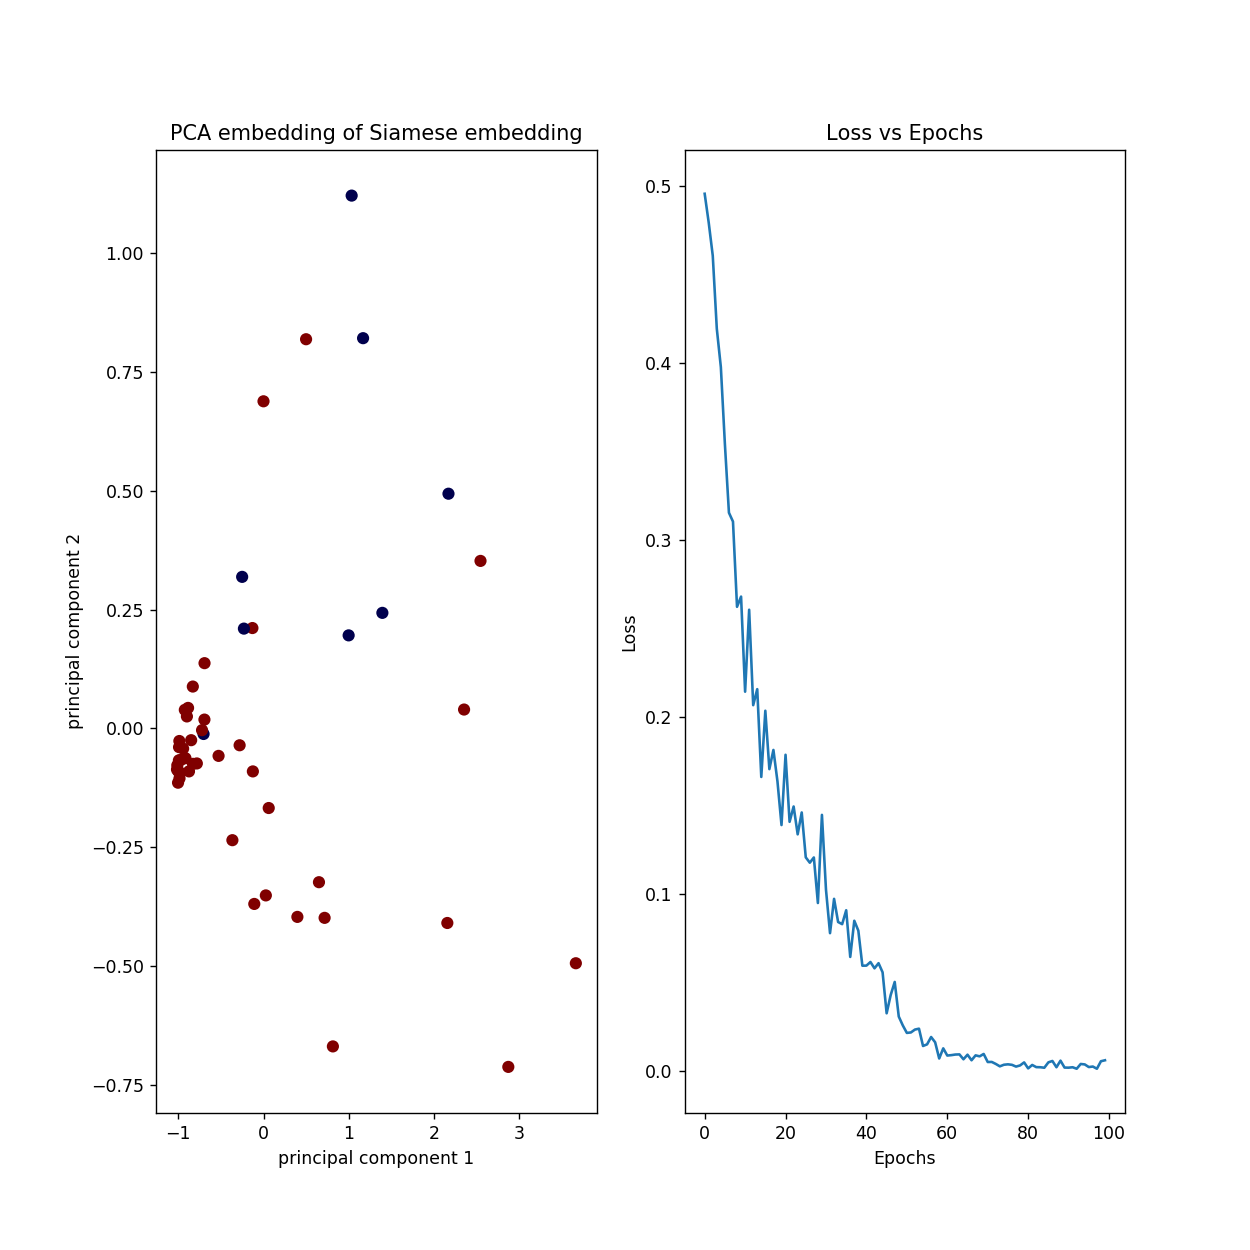

  ...
    to  
  ['...']


In [20]:
_ = net.fit(
    data_generator(batch_size, emb_dim),
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    verbose=False,
    callbacks=[
        PCAPlotter(plt, embedding_model, X, Y)
    ]
)

## Analysis

In [21]:
# https://medium.com/@crimy/one-shot-learning-siamese-networks-and-triplet-loss-with-keras-2885ed022352

def compute_dist(a,b):
    # TODO: Add square root and test.
    return np.sum(np.square(a-b))

def compute_probs(network,X,Y):
    '''
    Input
        network : current NN to compute embeddings
        X : tensor of shape (m,w,h,1) containing pics to evaluate
        Y : tensor of shape (m,) containing true class
        
    Returns
        probs : array of shape (m,m) containing distances
    
    '''
    m = X.shape[0]
    nbevaluation = int(m*(m-1)/2)
    probs = np.zeros((nbevaluation))
    y = np.zeros((nbevaluation))
    
    # Compute all embeddings for all pics with current network
    embeddings = network.predict(X)
    
    size_embedding = embeddings.shape[1]
    
    # For each pics of our dataset
    k = 0
    for i in range(m):
            # Against all other images
            for j in range(i+1,m):
                # compute the probability of being the right decision : it should be 1 for right class, 0 for all other classes
                probs[k] = -compute_dist(embeddings[i,:],embeddings[j,:])
                if (Y[i]==Y[j]):
                    y[k] = 1
                else:
                    y[k] = 0
                k += 1
    return probs,y

from sklearn.metrics import roc_auc_score, roc_curve
def compute_metrics(probs,yprobs):
    '''
    Returns
        fpr : Increasing false positive rates such that element i is the false positive rate of predictions with score >= thresholds[i]
        tpr : Increasing true positive rates such that element i is the true positive rate of predictions with score >= thresholds[i].
        thresholds : Decreasing thresholds on the decision function used to compute fpr and tpr. thresholds[0] represents no instances being predicted and is arbitrarily set to max(y_score) + 1
        auc : Area Under the ROC Curve metric
    '''
    # calculate AUC
    auc = roc_auc_score(yprobs, probs)
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(yprobs, probs)
    
    return fpr, tpr, thresholds, auc

In [22]:
n_val = 100

# Computes the distances of the embeddings of the images against each other and
# their probability of being correct.
# probs - Contains the embedding distances.
# yprob - Contains the probability of being correct.
probs, yprob = compute_probs(embedding_model,x_test[:n_val],y_test[:n_val])

In [23]:
# Compute the false positive rate (FPR), the true positive rate (TPR), the thresholds on the decision function used to compute FPR and TPR,
# and the area under the ROC Curve metric.
fpr, tpr, thresholds, auc = compute_metrics(probs,yprob)
print(fpr)
print(tpr)

[0.         0.         0.         0.00297619 0.00297619 0.00595238
 0.00595238 0.00892857 0.00892857 0.01190476 0.01190476 0.01488095
 0.01488095 0.01785714 0.01785714 0.02083333 0.02083333 0.02380952
 0.02380952 0.02678571 0.02678571 0.0297619  0.0297619  0.0327381
 0.0327381  0.03571429 0.03571429 0.04166667 0.04166667 0.05357143
 0.05357143 0.05654762 0.05654762 0.05952381 0.05952381 0.0625
 0.0625     0.06547619 0.06547619 0.06845238 0.06845238 0.07142857
 0.07142857 0.07440476 0.07440476 0.08035714 0.08035714 0.08333333
 0.08333333 0.08630952 0.08630952 0.08928571 0.08928571 0.0952381
 0.0952381  0.09821429 0.09821429 0.10119048 0.10119048 0.10416667
 0.10416667 0.10714286 0.10714286 0.11309524 0.11309524 0.11607143
 0.11607143 0.125      0.125      0.13392857 0.13392857 0.13690476
 0.13690476 0.13988095 0.13988095 0.14880952 0.14880952 0.15178571
 0.15178571 0.1547619  0.1547619  0.17261905 0.17261905 0.17857143
 0.17857143 0.19345238 0.19345238 0.19642857 0.19642857 0.19940476
 

/opt/rh/rh-python36/root/usr/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


<IPython.core.display.Javascript object>


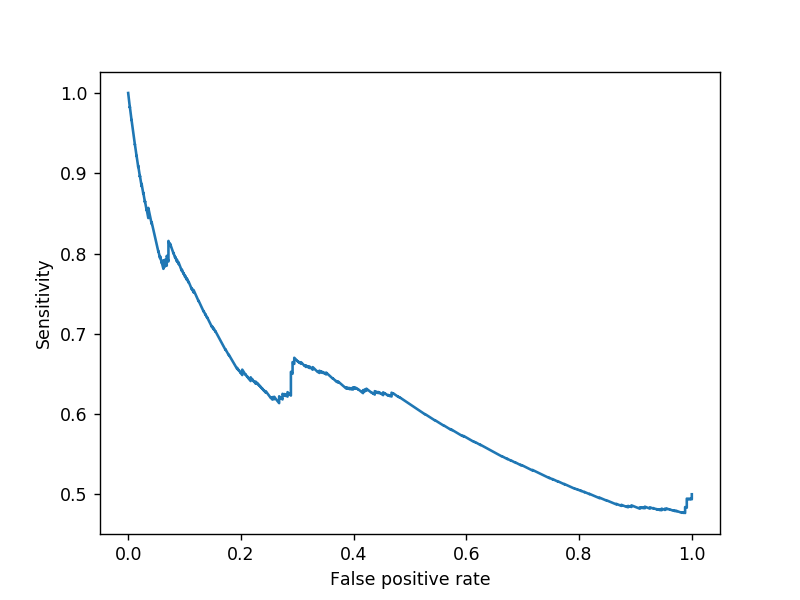

In [24]:
# Plot sensitivity as function of false positive rate (fpr)
sensitivity = tpr/(fpr+tpr)
plt.figure()
plt.plot(fpr,sensitivity); 
plt.xlabel('False positive rate')
plt.ylabel('Sensitivity')
plt.show()

<IPython.core.display.Javascript object>


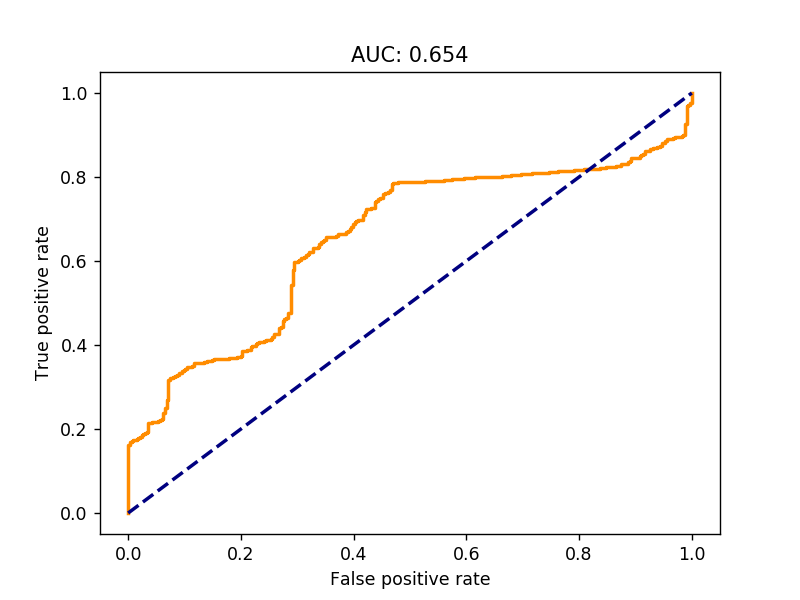

In [25]:
# ROC curve and Area under the curve (AUC)
plt.figure()
plt.plot(fpr,tpr, color='darkorange', lw=2, linestyle='-');
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--');
plt.xlabel('False positive rate'); 
plt.ylabel('True positive rate');
plt.title('AUC: {:.3f}'.format(auc))
plt.show()

<IPython.core.display.Javascript object>


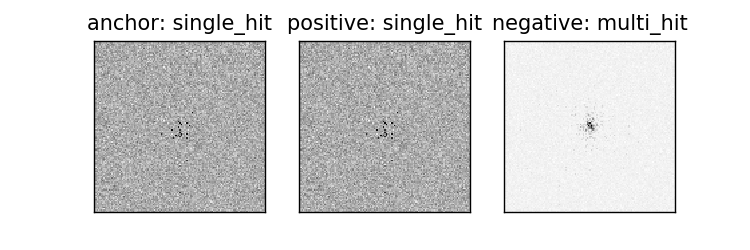

Dp: 0.0, Dn: 5.087275297161054
32


In [26]:
# Print Dp and Dn
triplet, labels = create_batch(batch_size=1, anchor_label=0)

myBatch = np.zeros((3, emb_dim))
myBatch[0,:] = embedding_model.predict(triplet[0])
myBatch[1,:] = embedding_model.predict(triplet[1])
myBatch[2,:] = embedding_model.predict(triplet[2])
plot_triplet(triplet, labels)

# Calculate the Euclidean distance between the embeddings in myBatch
from scipy.spatial.distance import cdist
Y = cdist(myBatch, myBatch, 'euclidean')
print("Dp: {}, Dn: {}".format(Y[0,1],Y[0,2]))

print(len(myBatch[0]))

<IPython.core.display.Javascript object>


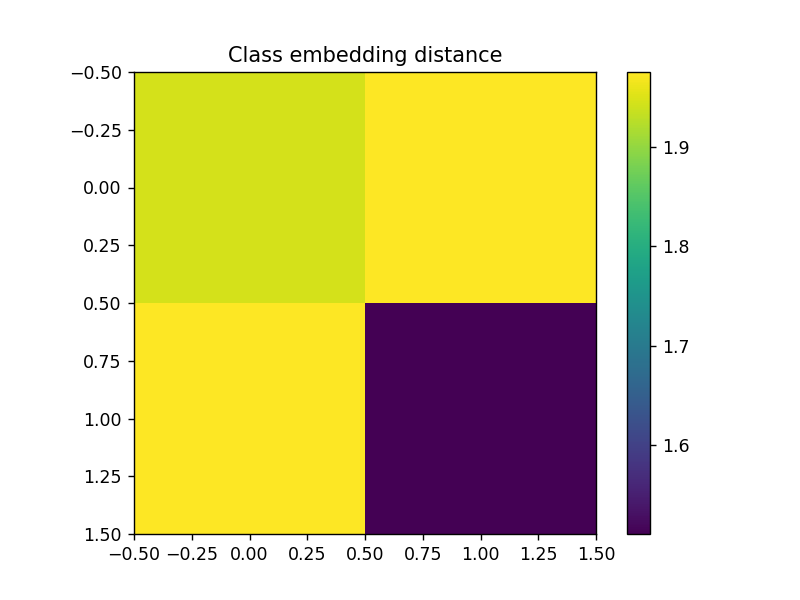

In [27]:
# Look at class embedding distance

# Embed first 1000 test images
num_sample = 50
num_classes = 2
junk = x_test[:num_sample]
junky = y_test[:num_sample]
emb_junk = np.zeros((num_sample,emb_dim))
for i in range(num_sample):
    emb_junk[i,:] = embedding_model.predict(np.expand_dims(junk[i,:], axis=0)) 

# Calculate euclidean distance between embeddings
Y = cdist(emb_junk,emb_junk,'euclidean')

# Populate class embedding distance matrix
distance_matrix = np.zeros((num_classes,num_classes))
counter = np.zeros((num_classes,num_classes))
for i in range(num_sample):
    for j in range(i+1,num_sample):
        class1 = junky[i]
        class2 = junky[j]
        distance_matrix[class1,class2] += Y[i,j]
        distance_matrix[class2,class1] += Y[i,j]
        counter[class1,class2] += 1
        counter[class2,class1] += 1
distance_matrix = distance_matrix/counter

# Visualize
plt.figure(); plt.imshow(distance_matrix,interpolation='None'); 
plt.title("Class embedding distance"); plt.colorbar(); plt.show()

In [28]:
# See which classes are hard and easy to distinguish from each other

# Input an integer here that represents a class. In the case of this network:
# 0 = Single-Hit Image
# 1 = Multi-Hit Image
myClass = 0

# select hardest and easiest classes based on mean distance
dist = distance_matrix[myClass,:] 
challenging = np.argsort(dist)
hardest = None
hscore = 0
easiest = None
escore = 0
cscore = dist[myClass]
for i in challenging:
    if i != myClass:
        hardest = i
        hscore=dist[i]
        break
for i in reversed(challenging):
    if i != myClass:
        easiest = i
        escore=dist[i]
        break        
print("For PDB {} ({:.3f}), hardest class to distinguish is digit {} ({:.3f}) and easiest digit is {} ({:.3f})"
      .format(idx2hit[myClass],cscore,idx2hit[hardest],hscore,idx2hit[easiest],escore))

For PDB single_hit (1.945), hardest class to distinguish is digit multi_hit (1.975) and easiest digit is multi_hit (1.975)


# New Prediction Function 8-17-21

In [29]:
from scipy.spatial.distance import euclidean

def predict_using_anchors(anchor_single, anchor_multi, unknown):
    """
    Predict whether an unknown image is a single-hit or multi-hit image by
    comparing it against an anchor single-hit image and an anchor multi-hit image.
    
    Parameters
    ----------
    anchor_single: numpy.array
        Anchor image for a single-hit image.
    anchor_multi: numpy.array
        Anchor image for multi-hit image.
    unknown: numpy.array
        Unknown image to get prediction from.
        
    Return
    ------
    0 if the unknown image is single-hit and a 1 if the unknown image is a multi-hit.
    """
    # Expand dimensions by one in axis 0 so that it matches input for embedding model.
    anchor_single = np.expand_dims(anchor_single, axis=0)
    anchor_multi = np.expand_dims(anchor_multi, axis=0)
    unknown = np.expand_dims(unknown, axis=0)
    
    # Calculate the embedding vectors of the anchor single-hit image, anchor multi-hit image,
    # and unknown image.
    anc_single_emb = embedding_model.predict(anchor_single)
    anc_multi_emb = embedding_model.predict(anchor_multi)
    anc_unknown_emb = embedding_model.predict(unknown)
    
    # Calculate Euclidean distance between the embedding vectors
    d_su = euclidean(anc_single_emb, anc_unknown_emb)  # Distance between anchor single-hit and unknown
    d_mu = euclidean(anc_multi_emb, anc_unknown_emb)   # Distance between anchor multi-hit and unknown
    
    # Determine which distance is the smallest, and return a prediction
    if (d_su < d_mu):
        # Unknown image is single-hit
        return 0
    else:
        # Unknown image is multi-hit
        return 1

In [30]:
def sample_anchor_and_unknown_images(images, labels, seed=1234):
    """
    Samples an anchor single-hit image, and anchor multi-hit image, and an unknown image
    from given image dataset.
    
    Parameters
    ----------
    images: list(numpy.array)
        List of diffraction images to sample multi-hit and single-hit images from.
    labels: list(int)
        List of integers representing the labels of the images given.
        0 = single-hit
        1 = multi-hit
    seed: int (optional)
        Seed used to initialize random number generation.
    
    Return
    ------
    (anc_single, anc_multi, unknown): tuple of numpy.array
        anc_single: numpy.array
            Anchor image for single-hit image.
        anc_multi: numpy.array
            Anchor image for multi-hit image.
        unknown: numpy.array
            Unknown image to compare against.
            
    (anc_single_label, anc_multi_label, unknown_label): tuple of int
        anc_single_label: int
            Integer representing the label of the anchor single-hit image.
            Will always be 0 as it is a single-hit image.
        anc_multi_label: int
            Integer representing the label of the anchor multi-hit image.
            Will always be 1 as it is a multi-hit image.
        unknown_label: int
            Integer representing the label of the unknown image.
    """
    
    # Images to return
    anc_single = None
    anc_multi = None
    unknown = None
    
    # Label of images to return
    anc_single_label = None
    anc_multi_label = None
    unknown_label = None
    
    # Seed random number generator.
    np.random.seed(seed=seed)
    
    # Get size of dataset.
    dataset_size = len(images)
    
    # List of indices with single-hit images and multi-hit images
    anc_single_indices = np.squeeze(np.where(labels == hit2idx['single_hit']))
    anc_multi_indices = np.squeeze(np.where(labels == hit2idx['multi_hit']))
    
    # List of indices we got an anchor image from.
    # Makes sure we do not accidently sample the same images for unknown image.
    sampled_indices = []
    
    """Get an anchor single-hit image"""
    # 1. Get an index of a single-hit image.
    idx = anc_single_indices[np.random.randint(0, high=len(anc_single_indices))]

    # 2. Record that index in sampled_indices.
    sampled_indices.append(idx)

    # 3. Set anc_single as image at idx
    anc_single = images[idx]

    # 4. Set anc_single_label with label value
    anc_single_label = labels[idx]
        
    """ Get an anchor multi-hit image """
    # 1. Get an index of a single-hit image.
    idx = anc_multi_indices[np.random.randint(0, high=len(anc_multi_indices))]

    # 2. Record that index in sampled_indices.
    sampled_indices.append(idx)

    # 3. Set anc_multi as image at idx.
    anc_multi = images[idx]

    # 4. Set anc_multi_label with label value.
    anc_multi_label = labels[idx]
        
    """ Get an unknown image """
    while True:
        # 1. Get a random index to look at.
        idx = np.random.randint(0, high=dataset_size)
        
        # 2. Check to see if this idx was sampled before. If not, make this image the unknown image.
        if (idx not in sampled_indices):
            # Add idx to indices sampled.
            sampled_indices.append(idx)
            
            # Set unknown as image at idx
            unknown = images[idx]
            
            # Set unknown_label with label value
            unknown_label = labels[idx]
            
            # Break from loop
            break
        else:
            pass
    
    return (anc_single, anc_multi, unknown), (anc_single_label, anc_multi_label, unknown_label)

#### Create a test image batch for testing the model now that it is trained.

In [31]:
# Create a batch of "raw" triplets. That is, a batch of anchor, positive, and negative triplets.
test_img_raw, test_labels_raw = create_batch(batch_size=1000)

# Extract anchor images and labels from the "raw" triplets
test_imgs = test_img_raw[0]
test_labels = test_labels_raw[0]

#### Sample an anchor single-hit image, an anchor multi-hit image, and an unknown image.

In [32]:
# Sample an anchor single-hit image, an anchor multi-hit image, and an unknown image.
# (anc_single, anc_multi, unknown), (anc_single_label, anc_multi_label, unknown_label)
sampled_imgs, sampled_imgs_labels = sample_anchor_and_unknown_images(test_imgs, test_labels, seed=1234)

# Extract anchor and unknown images.
anc_single = sampled_imgs[0]
anc_multi = sampled_imgs[1]
unknown = sampled_imgs[2]

# Extract anchor and unknown image labels.
anc_single_label = sampled_imgs_labels[0]
anc_multi_label = sampled_imgs_labels[1]
unknown_label = sampled_imgs_labels[2]

#### Make a prediction using the anchor and unknown images, and print out information about them.

In [33]:
# Make a prediction using the sampled images.
prediction = predict_using_anchors(anc_single, anc_multi, unknown)

# Prediction information
print('Anchor single-hit label: ' + idx2hit[anc_single_label])
print('Anchor multi-hit label: ' + idx2hit[anc_multi_label])
print('Prediction for Unknown: ' + idx2hit[prediction])
print('Ground Truth for Unknown: ' + idx2hit[unknown_label])

Anchor single-hit label: single_hit
Anchor multi-hit label: multi_hit
Prediction for Unknown: single_hit
Ground Truth for Unknown: single_hit


# Accuracy, Precision, Recall, and F1 Score

In [ ]:
import sklearn.metrics

def accuracy_precision_recall_and_f1(y_true, y_pred):
    """
    Returns the accuracy, precision, recall, and F1 scores.
    
    Parameters
    ----------
    y_true -> An array of the correct target values. 0 means single-hit and 1 means multi-hit (so double, triple, or quadruple).
    y_pred -> An array of the predicted target values by model. 0 means single-hit and 1 means multi-hit (so double, triple, or quadruple)
    
    Return
    ------
    accuracy: float
        The accuracy of the model on given test set.
    precision: float
        The precision of the model on given test set.
    recall: float
        The recall of the model on given test set.
    f1_score: float
        The F1 score of the model on given test set.
    """

    accuracy = sklearn.metrics.accuracy_score(y_true=y_true, y_pred=y_pred)
    
    # pos_label = 0 to return precision for classifying single-hit images.
    precision = sklearn.metrics.precision_score(y_true=y_true, y_pred=y_pred, pos_label=0, average='binary', zero_division='warn')

    # pos_label = 0 to return recall for classifying single-hit images.
    recall = sklearn.metrics.recall_score(y_true=y_true, y_pred=y_pred, pos_label=0, average='binary', zero_division='warn')

    # pos_label = 0 to return F1 score for classifying single-hit images.
    f1_score = sklearn.metrics.f1_score(y_true=y_true, y_pred=y_pred, pos_label=0, average='binary', zero_division='warn')
    
    return accuracy, precision, recall, f1_score

In [ ]:
# Compute accuracy, precision, recall, and F1 score of model on a test set.
accuracy, precision, recall, f1 = accuracy_precision_recall_and_f1(y_true, y_pred)
print('Accuracy: {}'.format(accuracy))
print('Precision: {}'.format(precision))
print('Recall: {}'.format(recall))
print('F1 Score: {}'.format(f1))

# Create visualization of model architecture

In [ ]:
tf.keras.utils.plot_model(
    net,
    to_file="twin_network.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=300,
)

# Create collage of labeled diffraction images

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import numpy as np
from textwrap import wrap
from pylab import cm

# Font, font size, and axes line width of plots.
mpl.rcParams['font.family'] = 'Avenir'
plt.rcParams['font.size'] = 20
plt.rcParams['axes.linewidth'] = 0

# Images to plot with their predicted and ground-truth labels.
imgs = x_test[1][20:40]
predictions = y_pred[20:40]
true_values = y_true[20:40]
print(predictions)

# Setup the collage plot.
nrows = 4
ncols = 5
fig, axs = plt.subplots(nrows=nrows, ncols=ncols)
fig.set_size_inches((24, 24))

# Plot the collage.
curr_row = 0
curr_col = 0
idx = 0
for img in imgs:
    
    # Predicted and ground truth labels.
    str_classified_label = ''
    str_true_label = ''
    
    # Determine the predicted label.
    if (predictions[idx] == 0):
        # Single-hit classified
        str_classified_label = 'Single-Hit'
    else:
        # Multi-hit classified
        str_classified_label = 'Multi-Hit'
        
    # Determine the ground-truth label. 
    if (true_values[idx] == 0):
        # Single-hit true
        str_true_label = 'Single-Hit'
    else:
        # Multi-hit true
        str_true_label = 'Multi-Hit'
        
    # Update index value used to traverse through image datasets.
    idx = idx + 1
    
    # Set subplot titles as "Prediction"/"Ground Truth"
    axs[curr_row, curr_col].set_title(str_classified_label + ' / ' + str_true_label)
    
    # set visibility of x-axis as False
    xax = axs[curr_row, curr_col].axes.get_xaxis()
    xax = xax.set_visible(False)
  
    # set visibility of y-axis as False
    yax = axs[curr_row, curr_col].axes.get_yaxis()
    yax = yax.set_visible(False)
    
    # Plot the diffraction image.
    axs[curr_row, curr_col].imshow(np.reshape(img, (dim_r, dim_c)), vmin=0, vmax=5)
    
    # Update curr_col to traverse through subplot.
    curr_col = curr_col + 1
    
    # If curr_col == ncols of the figure, move onto the next row
    # starting at the left.
    if (curr_col == ncols):
        curr_col = 0
        curr_row = curr_row + 1
    else:
        pass

# Save classification collage with publication quality.
image_name = 'classified_images.png'
plt.savefig(image_name, dpi=300, transparent=False, bbox_inches='tight')

# Show the collage.
plt.show()

# For Demo

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import numpy as np
from textwrap import wrap
from pylab import cm

def display_diffraction_img_and_prediction(random_number):

    # Edit the font, font size, and axes width
    mpl.rcParams['font.family'] = 'Avenir'
    plt.rcParams['font.size'] = 20
    plt.rcParams['axes.linewidth'] = 0

    # Images to possibly display.
    imgs = x_test[1]     # Get positive images.
    predictions = y_pred
    true_values = y_true

    # Setup the matplotlib plot.
    nrows = 1
    ncols = 1
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols)
    fig.set_size_inches((4, 4))

    # Prediction and ground truth labels.
    str_classified_label = ''
    str_true_label = ''
    
    # Determine the prediction label.
    if (predictions[random_number] == 0):
        # Single-hit classified
        str_classified_label = 'Prediction: Single-Hit'
    else:
        # Multi-hit classified
        str_classified_label = 'Prediction: Multi-Hit'
        
    # Determine the ground truth label.
    if (true_values[random_number] == 0):
        # Single-hit true
        str_true_label = 'Ground Truth: Single-Hit'
    else:
        # Multi-hit true
        str_true_label = 'Ground Truth: Multi-Hit'
    
    # Set the plot's title to be "Prediction" on the first line and "Ground Truth"
    # on the next line.
    axs.set_title(str_classified_label + '\n' + str_true_label)
    
    # set visibility of x-axis as False
    xax = axs.axes.get_xaxis()
    xax = xax.set_visible(False)
  
    # set visibility of y-axis as False
    yax = axs.axes.get_yaxis()
    yax = yax.set_visible(False)
    
    # Plot the diffraction image at the location of the given random number.
    axs.imshow(np.reshape(imgs[random_number], (dim_r, dim_c)), vmin=0, vmax=3)

    # Display the image with prediction and ground truth values.
    plt.show()

# Demo
### Pick a number between 0 and 999 to see a diffraction image, as well as the prediction the twin neural network made!

In [ ]:
RANDOM_NUMBER = 100
display_diffraction_img_and_prediction(RANDOM_NUMBER)